In [1]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files
from urllib.parse import urlparse
import tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import Sequential, Model
from time import time
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Input, Concatenate, BatchNormalization


In [2]:
# Upload CSV αρχειο
uploaded = files.upload()

Saving my_new_data.csv to my_new_data.csv


In [3]:
# Διαβάζουμε το CSV αρχείο μέσω του Pandas DataFrame
df = pd.read_csv(io.BytesIO(uploaded['my_new_data.csv']))

# Παρουσίαση πρώτων 5 γραμμών
df.head()

,url,type,Category,url_len,num_subdomains,num_dots,digits,special_chars,letters,Https,Shortening_Service,having_ip
0,br-icloud.com.br,phishing,2,16,0,2,0,3,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,2,1,5,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,2,1,5,25,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,0,2,7,17,60,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,2,22,14,199,0,0,0


In [4]:
# One-Hot Encoding των Ετικετών
y = to_categorical(df['Category'])

# Χαρακτηριστικό - ολόκληρο το URL
# Παίρνουμε τη στήλη με τα URLs
urls = df['url'].astype(str).tolist()

# Χρήση tokenizer χαρακτηριστικών (char-level)
char_tokenizer = Tokenizer(char_level=True, lower=False)
char_tokenizer.fit_on_texts(urls)

# Πλήθος μοναδικών χαρακτήρων
# Μέγεθος λεξικού (vocab_size)
vocab_size = len(char_tokenizer.word_index) + 1 # προσθέτουμε 1 για padding
# πίνακες με τα κωδικοποιημένα χαρακτηριστικά
url_sequences = char_tokenizer.texts_to_sequences(urls)
# μέγιστο μήκος
max_len = 230
# Padding ακολουθιών - ίδιο μήκος όλες οι ακολουθίες
# padding='post' - προσθήκη padding στο τέλος κάθε ακολουθίας
# truncating ='post' - περιορίζει το μήκος της ακολουθίας αφαιρώντας στοιχεία από το τέλος
padded_urls = pad_sequences(url_sequences, maxlen=max_len, padding='post', truncating='post')


In [5]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    start_time= time()

    # Εκπαίδευση του μοντέλου
    model.fit(X_train, y_train, epochs=7, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    training_time = time() - start_time

    # Αξιολόγηση μοντέλου στο test set
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

    # Προβλέψεις - επιστρέφει πιθανότητες (softmax)
    y_pred_prob = model.predict(X_test)
    # Κατηγορία με τη μεγαλύτερη πιθανότητα
    y_pred = np.argmax(y_pred_prob, axis=1)
    # Πραγματική κατηγορία από one-hot y_test
    y_true = np.argmax(y_test, axis=1)

    # Υπολογισμός μετρικών
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall= recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1= f1_score(y_true, y_pred, average='weighted', zero_division=0)

    # Εκτύπωση λεπτομερούς αναφοράς
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Πίνακας - Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

    return model_name, round(accuracy, 4), round(precision, 4), round(recall, 4) , round(f1, 4), round(training_time, 2)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3553s 886ms/step - accuracy: 0.6960 - loss: 0.8902 - val_accuracy: 0.8042 - val_loss: 0.4982
Epoch 2/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3407s 850ms/step - accuracy: 0.8669 - loss: 0.3547 - val_accuracy: 0.8990 - val_loss: 0.3892
Epoch 3/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3348s 835ms/step - accuracy: 0.9149 - loss: 0.2361 - val_accuracy: 0.9043 - val_loss: 0.2516
Epoch 4/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3304s 816ms/step - accuracy: 0.9326 - loss: 0.1893 - val_accuracy: 0.9378 - val_loss: 0.1710
Epoch 5/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3315s 827ms/step - accuracy: 0.9430 - loss: 0.1587 - val_accuracy: 0.9492 - val_loss: 0.1536
Epoch 6/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3238s 808ms/step - accuracy: 0.9498 - loss: 0.1389 - val_accuracy: 0.9524 - val_loss: 0.1450
Epoch 7/7
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 3343s 828ms/step - accuracy: 0.9546 - loss: 0.1251 - val_accuracy: 0.9543 - val_loss: 0.1269
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 460s 115ms/step

Classification

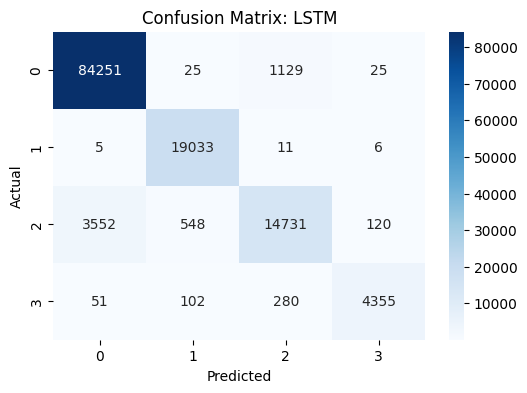

  Model  Accuracy  Precision  Recall  F1-Score  Training Time
0  LSTM    0.9543     0.9533  0.9543    0.9528       23508.76


In [6]:
# Εκπαίδευση με URL χαρακτηριστικό
X_train_url, X_test_url, y_train, y_test = train_test_split(padded_urls, y, test_size=0.2, random_state=42)

# Δημιουργία LSTM Μοντέλου
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128),
    BatchNormalization(),
    Dropout(0.3),
    # Πλήρως συνδεδεμένο επίπεδο
    Dense(64, activation='relu'),
    Dropout(0.3),
    # Τελική έξοδος
    Dense(4, activation='softmax')
])

results = []
# Σύνταξη του μοντέλου
lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

# Εκπαίδευση και Αξιολόγηση, προσθήκη στη τελική λίστα αποτελεσμάτων
results.append(train_and_evaluate(lstm_model, X_train_url, X_test_url, y_train, y_test, 'LSTM'))

# Παρουσίαση αποτελεσμάτων
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'])
print(results_df)



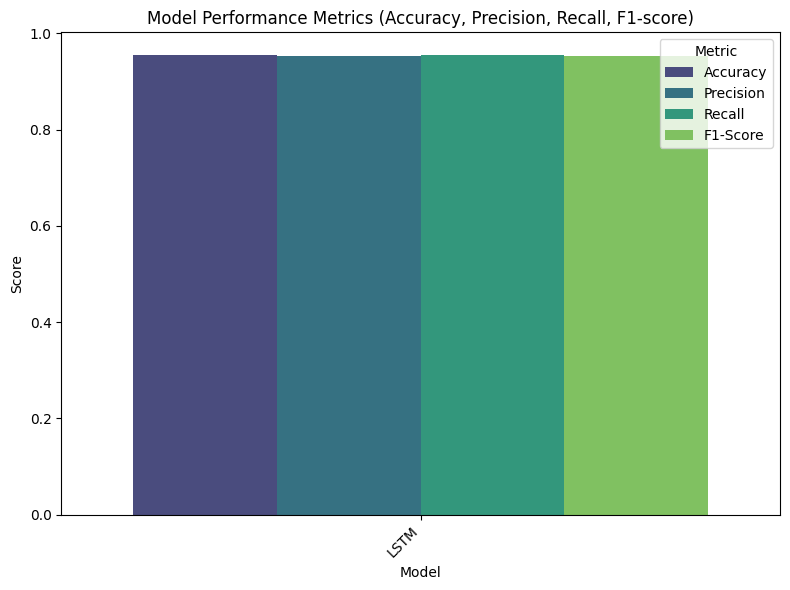

/tmp/ipython-input-3871309410.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')


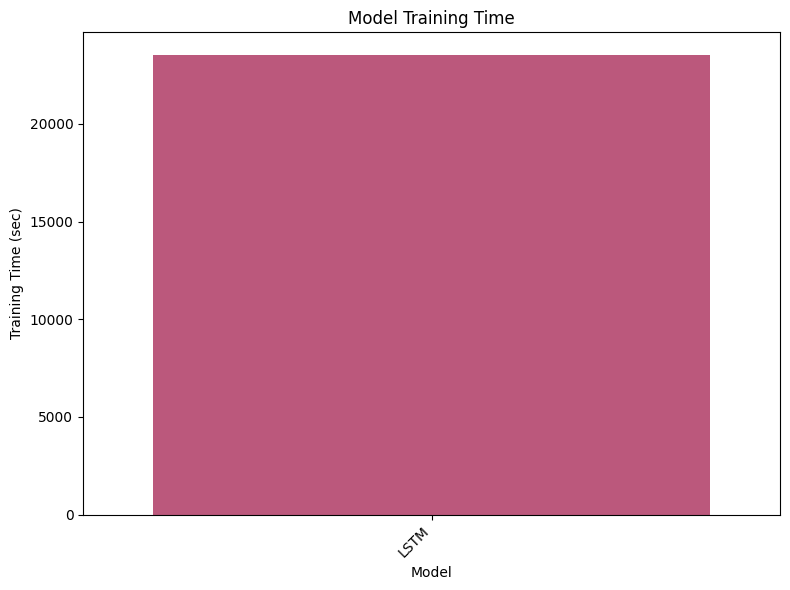

In [8]:
# Διάγραμμα συνολικών αποτελεσμάτων για κάθε μοντέλο (μετρικές και χρόνοι)

# Μετατροπή DataFrame για εύκολη σχεδίαση
results_melt = results_df.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    var_name='Metric',
    value_name='Score'
)

# Διάγραμμα μετρικών
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melt, palette='viridis')
plt.title('Model Performance Metrics (Accuracy, Precision, Recall, F1-score)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Διάγραμμα χρόνου εκπαίδευσης
plt.figure(figsize=(8,6))
sns.barplot(x='Model', y='Training Time', data=results_df, palette='plasma')
plt.title('Model Training Time')
plt.xlabel('Model')
plt.ylabel('Training Time (sec)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()